# Lab 15: Scientific Machine Learning
#### [Penn State Astroinformatics Summer School 2022](https://sites.psu.edu/astrostatistics/astroinfo-su22-program/)
#### Code minimally adapted from [Keith et al. 2021](https://arxiv.org/abs/2102.12695)
#### Questions provided by [Chris Rackauckas](https://chrisrackauckas.com/)

# Overview
In this lab, you will experiment with a neural ODE to model a gravitational wave form.  For details, see [Keith et al. 2021](https://arxiv.org/abs/2102.12695).

# Setup 
First, we need to make sure that the packages we'll use are installed on your system.
(The first time you run it, it may take a few minutes to install and pre-compile many packages. 
If so, it will output a long list of packages implicitly used by those packages.  You can ignore the output and scroll down to the next cell.)

In [1]:
import Pkg
if isfile(".")   # Try to save a little time if your Julia environment is already setup
    Pkg.activate(".")
    try
        using OrdinaryDiffEq
        using DiffEqFlux
        using Optim
        using LineSearches
        using DataFrames
        using CSV
        using Plots
    catch
        Pkg.instantiate()
    end
else               
    Pkg.activate(mktempdir())
    Pkg.add([
        Pkg.PackageSpec(name="OrdinaryDiffEq"),
        Pkg.PackageSpec(name="DiffEqFlux"),
        #Pkg.PackageSpec(name="DiffEqSensitivity"),
        Pkg.PackageSpec(name="Optim"),
        Pkg.PackageSpec(name="LineSearches"),
        Pkg.PackageSpec(name="DataFrames"),
        Pkg.PackageSpec(name="CSV"),
        Pkg.PackageSpec(name="Plots"),
    ])
end

  Activating new project at `/tmp/jl_cx56wK`
    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
   Installed Referenceables ─────────────────── v0.1.2
   Installed Enzyme_jll ─────────────────────── v0.0.32+0
   Installed OffsetArrays ───────────────────── v1.12.6
   Installed NonlinearSolve ─────────────────── v0.3.20
   Installed MutableArithmetics ─────────────── v1.0.4
   Installed StaticArrays ───────────────────── v1.4.7
   Installed DomainSets ─────────────────────── v0.5.10
   Installed NNlib ──────────────────────────── v0.8.7
   Installed LabelledArrays ─────────────────── v1.10.2
   Installed Bijections ─────────────────────── v0.1.4
   Installed RecursiveArrayTools ────────────── v2.29.2
   Installed Memoize ────────────────────────── v0.4.4
   Installed TriangularSolve ────────────────── v0.1.11
   Installed ThreadsX ───────────────────────── v0.1.10
   Installed Lea

  [71a1bf82] + NameResolution v0.1.5
  [8913a72c] + NonlinearSolve v0.3.20
  [d8793406] + ObjectFile v0.3.7
  [6fe1bfb0] + OffsetArrays v1.12.6
  [429524aa] + Optim v1.7.0
  [3bd65402] + Optimisers v0.2.6
  [7f7a1694] + Optimization v3.6.1
  [253f991c] + OptimizationFlux v0.1.0
  [36348300] + OptimizationOptimJL v0.1.1
  [42dfb2eb] + OptimizationOptimisers v0.1.0
  [500b13db] + OptimizationPolyalgorithms v0.1.0
  [bac558e1] + OrderedCollections v1.4.1
  [1dea7af3] + OrdinaryDiffEq v6.15.0
  [90014a1f] + PDMats v0.11.12
  [d96e819e] + Parameters v0.12.3
  [69de0a69] + Parsers v2.3.2
  [ccf2f8ad] + PlotThemes v3.0.0
  [995b91a9] + PlotUtils v1.2.0
  [91a5bcdd] + Plots v1.30.0
  [e409e4f3] + PoissonRandom v0.4.1
  [f517fe37] + Polyester v0.6.12
  [1d0040c9] + PolyesterWeave v0.1.5
  [2dfb63ee] + PooledArrays v1.4.2
  [85a6dd25] + PositiveFactorizations v0.2.4
  [d236fae5] + PreallocationTools v0.3.1
  [21216c6a] + Preferences v1.3.0
  [8162dcfd] + PrettyPrint v0.2.0
  [08abe8d2] + PrettyT

  [de0858da] + Printf
  [3fa0cd96] + REPL
  [9a3f8284] + Random
  [ea8e919c] + SHA
  [9e88b42a] + Serialization
  [1a1011a3] + SharedArrays
  [6462fe0b] + Sockets
  [2f01184e] + SparseArrays
  [10745b16] + Statistics
  [4607b0f0] + SuiteSparse
  [fa267f1f] + TOML
  [a4e569a6] + Tar
  [8dfed614] + Test
  [cf7118a7] + UUIDs
  [4ec0a83e] + Unicode
  [e66e0078] + CompilerSupportLibraries_jll
  [deac9b47] + LibCURL_jll
  [29816b5a] + LibSSH2_jll
  [c8ffd9c3] + MbedTLS_jll
  [14a3606d] + MozillaCACerts_jll
  [4536629a] + OpenBLAS_jll
  [05823500] + OpenLibm_jll
  [bea87d4a] + SuiteSparse_jll
  [83775a58] + Zlib_jll
  [8e850b90] + libblastrampoline_jll
  [8e850ede] + nghttp2_jll
  [3f19e933] + p7zip_jll
Precompiling project...
  ✓ MuladdMacro
  ✓ IntegerMathUtils
  ✓ GroupsCore
  ✓ CommonSolve
  ✓ CompositeTypes
  ✓ Underscores
  ✓ PoissonRandom
  ✓ Cassette
  ✓ AutoHashEquals
  ✓ GenericSchur
  ✓ StructIO
  ✓ Memoize
  ✓ RuntimeGeneratedFunctions
  ✓ ArrayInterfaceCore
  ✓ KrylovKit
  ✓ Fast

Next, we import the packages that we'll be using in this notebook.  (This cell can take considerable time while Julia compiles the packages and their many dependencies.)

In [2]:
using OrdinaryDiffEq
using DiffEqFlux
using Optim
using LineSearches
using DataFrames
using CSV
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


We'll load some code providing utility functions and definining ODE models.

In [3]:
include("utils.jl")
include("models.jl")

AbstractNROrbitModel (generic function with 1 method)

The next code cell defines the experimental parameters

In [4]:
mass_ratio = 0.0         # test particle
u0 = Float64[pi, 0.0]    # initial conditions
datasize = 250
tspan = (0.0f0, 6.0f4)   # timespace for GW waveform
tsteps = range(tspan[1], tspan[2], length = datasize)  # time at each timestep
dt_data = tsteps[2] - tsteps[1]   
dt = 100.0
model_params = [100.0, 1.0, 0.5]; # p, M, e

Next, we will compute the solution of the relativistic orbital model and plot the resuling gravitational waveform.

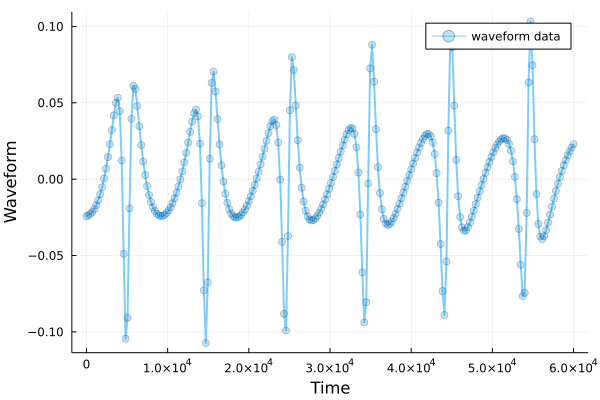

In [5]:
prob = ODEProblem(RelativisticOrbitModel, u0, tspan, model_params)
soln = Array(solve(prob, RK4(), saveat = tsteps, dt = dt, adaptive=false))
waveform = compute_waveform(dt_data, soln, mass_ratio, model_params)[1]
plt = plot(tsteps, waveform,
           markershape=:circle, markeralpha = 0.25,
           linewidth = 2, alpha = 0.5,
           label="waveform data", xlabel="Time", ylabel="Waveform")

Next, we define the neural network model that takes 1 input (time) and has two outputs.  We'll make a function `ODE_model` that takes the initial conditions, neural network parameters and a time as inputs and returns the derivatives.  (You can ignore the warning message.)

In [6]:
NN = FastChain((x, p) -> [cos(x[1])],
                FastDense(1, 32, cos),
                FastDense(32, 32, cos),
                FastDense(32, 2))

NN_params = initial_params(NN) .* 0

function ODE_model(u, NN_params, t)
    du = AbstractNNOrbitModel(u, model_params, t, NN=NN, NN_params=NN_params)
    return du
end

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux /home/eford/.julia/packages/DiffEqFlux/JicEk/src/fast_layers.jl:9


ODE_model (generic function with 1 method)

Next, we can compute the orbital trajectory and gravitational waveform using the neural network with its initial weights. 

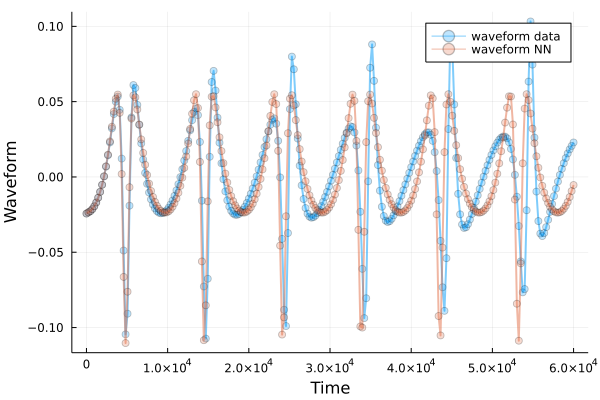

In [7]:
prob_nn = ODEProblem(ODE_model, u0, tspan, NN_params)
soln_nn = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params, saveat = tsteps, dt = dt, adaptive=false))
waveform_nn = compute_waveform(dt_data, soln_nn, mass_ratio, model_params)[1]
plot!(plt, tsteps, waveform_nn,
           markershape=:circle, markeralpha = 0.25,
           linewidth = 2, alpha = 0.5,
           label="waveform NN")
display(plt)

Next, we define the objective (loss) function to be minimized when training the neural differential equations.  (You'll modify the next code cell later.)

In [8]:
function loss(NN_params)
    first_obs_to_use_for_training = 1
    last_obs_to_use_for_training = length(waveform)
    obs_to_use_for_training = first_obs_to_use_for_training:last_obs_to_use_for_training 
    
    pred = Array(solve(prob_nn, RK4(), u0 = u0, p = NN_params, saveat = tsteps, dt = dt, adaptive=false))
    pred_waveform = compute_waveform(dt_data, pred, mass_ratio, model_params)[1]

    loss = ( sum(abs2, view(waveform,obs_to_use_for_training) .- view(pred_waveform,obs_to_use_for_training) ) )
    return loss, pred_waveform
end

loss (generic function with 1 method)

We can test the loss function and see that it returns a pair, a scalar loss and an array with the predicted waveform.    

In [9]:
loss(NN_params)

(0.17958934806509425, [-0.02426170124416641, -0.02347700387096864, -0.022692306497770928, -0.021366327514689577, -0.019471553300900196, -0.01696736390575786, -0.013801080654727665, -0.009904373072338206, -0.005195356638578907, 0.00042175563143324483  …  -0.023538517783925378, -0.02373328207660241, -0.02340563794726197, -0.022553498623215047, -0.021158343493800868, -0.019187553919868115, -0.016601411549141677, -0.013346910785275534, -0.009352827792888893, -0.005358744800502081])

We'll use the following to save the history of the loss values.

In [10]:
const losses = []

callback(θ,l,pred_waveform; doplot = true) = begin
    push!(losses, l)
    #=  Disable plotting as it trains since in Jupyter notebook
    display(l)
    # plot current prediction against data
    plt = plot(tsteps, waveform,
        markershape=:circle, markeralpha = 0.25,
        linewidth = 2, alpha = 0.5,
        label="wform data (h22)", legend=:topleft)
    plot!(plt, tsteps, pred_waveform,
        markershape=:circle, markeralpha = 0.25,
        linewidth = 2, alpha = 0.5,
        label = "wform NN")
    if doplot
        display(plot(plt))
    end
    # Tell sciml_train to not halt the optimization. If return true, then
    # optimization stops.
    =#
    return false
end

callback (generic function with 1 method)

## Train the Neural ODE
The next cell initializes the weights of the neural network and then trains the neural network.  (It takes several minutes to compile the first time.  If you retrain the model, it should only take ~5 seconds with the default parameters on subsequent calls.)
Training uses the BFGS optimizers.  This seems to give good results because the Newtonian model seems to give a very good initial guess.
(You'll come back to modify this cell later.)

In [11]:
NN_params = initial_params(NN) .* 0 + Float64(1e-3)*randn(eltype(NN_params), size(NN_params))
res = DiffEqFlux.sciml_train(loss, NN_params, BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()), cb=callback, maxiters = 20);

┌ Warning: sciml_train is being deprecated in favor of direct usage of Optimization.jl. Please consult the Optimization.jl documentation for more details. Optimization.jl's PolyOpt solver is the polyalgorithm of sciml_train
└ @ DiffEqFlux /home/eford/.julia/packages/DiffEqFlux/JicEk/src/train.jl:6


Now, we'll plot the learned solutions of the neural ODE and compare them to our full physical model and the Newtonian model. 

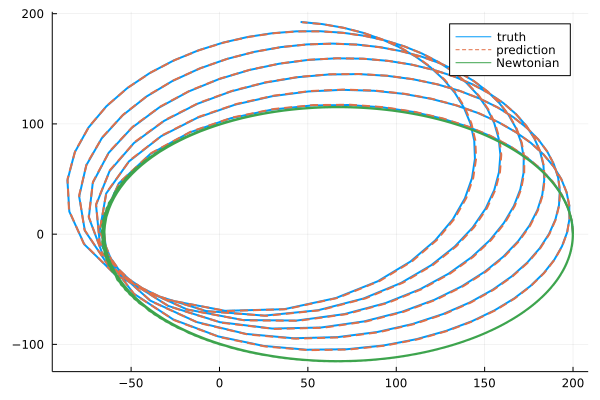

In [12]:
reference_solution = solve(remake(prob, p = model_params, saveat = tsteps, tspan=tspan),
                            RK4(), dt = dt, adaptive=false)

optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = tsteps, tspan=tspan),
                            RK4(), dt = dt, adaptive=false)
Newtonian_prob = ODEProblem(NewtonianOrbitModel, u0, tspan, model_params)

Newtonian_solution = solve(remake(Newtonian_prob, p = model_params, saveat = tsteps, tspan=tspan),
                            RK4(), dt = dt, adaptive=false)

true_orbit = soln2orbit(reference_solution, model_params)
pred_orbit = soln2orbit(optimized_solution, model_params)
Newt_orbit = soln2orbit(Newtonian_solution, model_params)

true_waveform = compute_waveform(dt_data, reference_solution, mass_ratio, model_params)[1]
pred_waveform = compute_waveform(dt_data, optimized_solution, mass_ratio, model_params)[1]
Newt_waveform = compute_waveform(dt_data, Newtonian_solution, mass_ratio, model_params)[1]

true_orbit = soln2orbit(reference_solution, model_params)
pred_orbit = soln2orbit(optimized_solution, model_params)
Newt_orbit = soln2orbit(Newtonian_solution, model_params)
plt = plot(true_orbit[1,:], true_orbit[2,:], linewidth = 2, label = "truth")
plot!(plt, pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt, Newt_orbit[1,:], Newt_orbit[2,:], linewidth = 2, label = "Newtonian")
display(plot(plt))

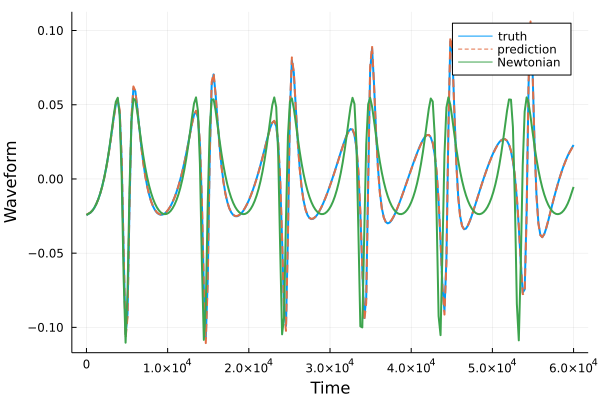

In [13]:
plt = plot(tsteps,true_waveform, linewidth = 2, label = "truth", xlabel="Time", ylabel="Waveform")
plot!(plt,tsteps,pred_waveform, linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt,tsteps,Newt_waveform, linewidth = 2, label = "Newtonian")

Now we'll do the same, but extrapolating the model out in time.

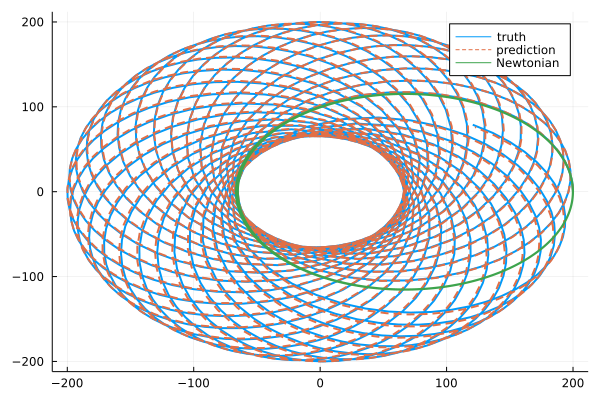

In [14]:
factor=5

extended_tspan = (tspan[1], factor*tspan[2])
extended_tsteps = range(tspan[1], factor*tspan[2], length = factor*datasize)
reference_solution = solve(remake(prob, p = model_params, saveat = extended_tsteps, tspan=extended_tspan),
                            RK4(), dt = dt, adaptive=false)
optimized_solution = solve(remake(prob_nn, p = res.minimizer, saveat = extended_tsteps, tspan=extended_tspan),
                            RK4(), dt = dt, adaptive=false)
Newtonian_prob = ODEProblem(NewtonianOrbitModel, u0, tspan, model_params)
Newtonian_solution = solve(remake(Newtonian_prob, p = model_params, saveat = extended_tsteps, tspan=extended_tspan),
                            RK4(), dt = dt, adaptive=false)
true_orbit = soln2orbit(reference_solution, model_params)
pred_orbit = soln2orbit(optimized_solution, model_params)
Newt_orbit = soln2orbit(Newtonian_solution, model_params)
plt = plot(true_orbit[1,:], true_orbit[2,:], linewidth = 2, label = "truth")
plot!(plt, pred_orbit[1,:], pred_orbit[2,:], linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt, Newt_orbit[1,:], Newt_orbit[2,:], linewidth = 2, label = "Newtonian")
display(plot(plt))

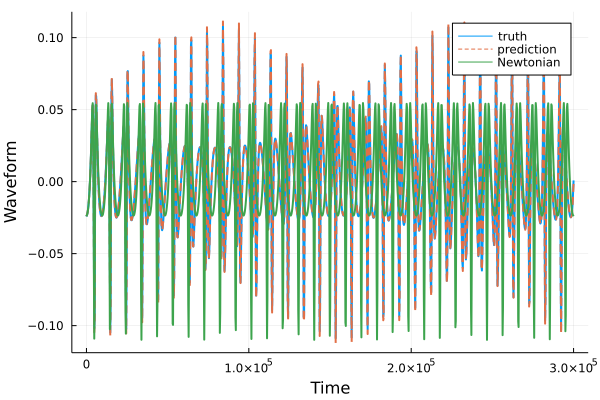

In [15]:
true_waveform = compute_waveform(dt_data, reference_solution, mass_ratio, model_params)[1]
pred_waveform = compute_waveform(dt_data, optimized_solution, mass_ratio, model_params)[1]
Newt_waveform = compute_waveform(dt_data, Newtonian_solution, mass_ratio, model_params)[1]
plt = plot(extended_tsteps,true_waveform, linewidth = 2, label = "truth", xlabel="Time", ylabel="Waveform")
plot!(plt,extended_tsteps,pred_waveform, linestyle = :dash, linewidth = 2, label = "prediction")
plot!(plt,extended_tsteps,Newt_waveform, linewidth = 2, label = "Newtonian")
display(plot(plt))

**Question 1:**
The first code cell in the section "Train the Neural ODE", sets 
```julia 
NN_params = initial_params(NN) .* 0 + Float64(1e-3)*randn(eltype(NN_params), size(NN_params))
```
i.e. it generates an array of zeros with size equal to the number of neural network weights, adds a little bit of randomness, and starts the training from there. Why? 

**Hint:** Try initializing the weights with significantly larger random weights.  Or Try initializing the weights with random values around 1.  Retrain the model.  What happens to its predictions?

**Question 2:**
Change the values of the variables `first_obs_to_use_for_training` and `last_obs_to_use_for_training` in the loss function, so that the neural network is trained using only a subset of the data.
How sensitive is the solution to the amount of data used for training?    